In [ ]:
import pandas as pd
import numpy as np
import random
import scipy
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

Мы будем анализировать результаты A/B тестирования двух версий дизайна кнопки сайта интернет-магазина.
Целевым действием считаем клик по этой кнопке.
Первые три этапа А/В тестирования за нас провели, результаты предоставили в виде файла ab_dataset.csv. Нам осталось выполнить четвертый пункт.

In [2]:
df = pd.read_csv('ab_datas.csv')
df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


In [3]:
n_rows = df.shape[0]
print(f"Число строк: {n_rows}") 

Число строк: 294478


In [4]:
user_total = df.nunique()['user_id']
print(f"Число уникальных пользователей : {user_total}")

Число уникальных пользователей : 290584


In [5]:
mismatch_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print(f"Из тестовой группы неверно направлены {len(mismatch_1)} пользователей")
mismatch_2 = df.query("group == 'control' and landing_page == 'new_page'")
print(f"Из контрольной группы неверно направлены  {len(mismatch_2)} пользователей")

Из тестовой группы неверно направлены 1965 пользователей
Из контрольной группы неверно направлены  1928 пользователей


In [6]:
p_all=df['converted'].mean()
print(f"Конверсия по всем посетителям: {p_all*100} %")

Конверсия по всем посетителям: 11.96591935560551 %


In [7]:
df_grp = df.groupby('group')
df_grp.describe()

user_id                                                   \
              count           mean           std       min       25%   
group                                                                  
control    147202.0  788123.098035  91278.896888  630002.0  709287.0   
treatment  147276.0  787825.226283  91142.800641  630000.0  708729.5   

                                         converted            ...            \
                50%        75%       max     count      mean  ...  75%  max   
group                                                         ...             
control    788053.5  867155.50  945998.0  147202.0  0.120399  ...  0.0  1.0   
treatment  787837.5  866693.75  945999.0  147276.0  0.118920  ...  0.0  1.0   

            revenue                                                         
              count        mean         std  min  25%    50%    75%    max  
group                                                                       
control    147202.0   87.431896  102.424926  0.0  0.0    0.0  250.0  250.0  
treatment  147276.0  116.496238  102.732069  0.0  0.0  100.0  250.0  250.0  

[2 rows x 24 columns]

In [9]:
n_rows_treat = len(df[df['group'] == 'treatment'])
n_rows_contr = n_rows-n_rows_treat
print(f"Соотношение размеров тестовой и контрольной групп: {n_rows_treat/n_rows_contr}")
print(f"Вероятность, что новый пользователь будет направлен на версию со старым дизайном: {n_rows_treat/n_rows}")
print(f"Вероятность, что новый пользователь будет направлен на версию с новым дизайном: {n_rows_contr/n_rows}")

Соотношение размеров тестовой и контрольной групп: 1.0005027105609978
Вероятность, что новый пользователь будет направлен на версию со старым дизайном: 0.5001256460584492
Вероятность, что новый пользователь будет направлен на версию с новым дизайном: 0.49987435394155083


In [16]:
#Z-статистика
import statsmodels.api as sm
import statsmodels

convert_contr = sum(df.query("group == 'control'")['converted'])
convert_treat = sum(df.query("group == 'treatment'")['converted'])

z_score, p_value = sm.stats.proportions_ztest([convert_treat, convert_contr], [n_rows_treat, n_rows_contr], 
                                              alternative='larger')

print(f"Z-статистика={z_score},  p_value={p_value}")


Z-статистика=-1.2369217547321678,  p_value=0.8919419336512124


In [18]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(df.query("group == 'treatment'")['converted'],
                                                              df.query("group == 'control'")['converted'],
                                                              alternative="larger",
                                                              usevar='unequal')
print(f"T-статистика={t_score},  p_value={p_value}")

T-статистика=-1.2369191070650987,  p_value=0.8919409489056582


In [20]:
w_score, p_value = scipy.stats.mannwhitneyu(df.query("group == 'treatment'")['converted'], 
                         df.query("group == 'control'")['converted'],
                         alternative="greater")
print(f"W-статистика={w_score},  p_value={p_value}")

W-статистика=10823622516.0,  p_value=0.8919415509213815


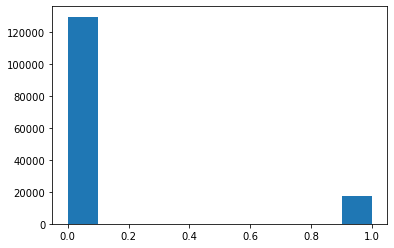

In [37]:
plt.hist(df.loc[df['group']=='treatment', 'converted']);

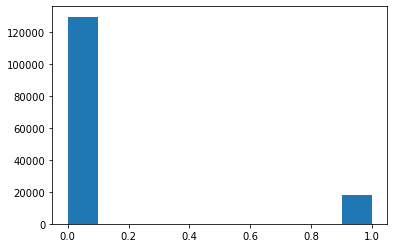

In [22]:
plt.hist(df.loc[df['group']=='control', 'converted']);

In [23]:
b = df.loc[df['group']=='treatment', 'converted'].values
a = df.loc[df['group']=='control', 'converted'].values

In [24]:
from sklearn.utils import resample

a_means = []
b_means = []

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

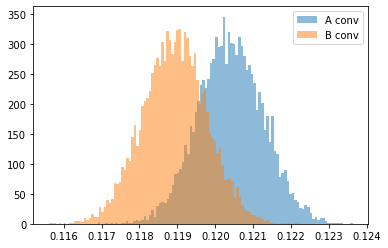

In [25]:
plt.hist(a_means, label='A conv', alpha=0.5, bins=100)
plt.hist(b_means, label='B conv', alpha=0.5, bins=100)

plt.legend()
plt.show()

In [26]:
# доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(0.11872783657830736, 0.12209752584883357)

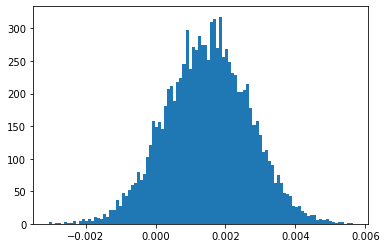

In [27]:
plt.hist(a_means - b_means, bins=100)
plt.show()

In [28]:
# сделаем оценку на p_value
dff = a_means - b_means
len(dff[dff>=0])/len(dff)

0.8909

*Задание *

Провести аналогичные исследования но для чека покупок клиентов (колонки revenue) в интернет магазине есть 2-ва типа продуктов:

100 руб.
250 руб.
ну и конечно клиент может ничего не купить
провести исследование изменился ли средний чек

In [50]:
mean_revenue_treat = df.loc[df['group'] == 'treatment','revenue'].mean()
mean_revenue_contr = df.loc[df['group'] == 'control','revenue'].mean()
print(f'Средний чек для тестовой группы: {mean_revenue_treat}, Средний чек для контрольной группы: {mean_revenue_contr}')

Средний чек для тестовой группы: 116.49623835519705, Средний чек для контрольной группы: 87.43189630575671


In [67]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(df.query("group == 'treatment'")['revenue'],
                                                              df.query("group == 'control'")['revenue'],
                                                              alternative="smaller",
                                                              usevar='unequal')
print(f"T-статистика={t_score},  p_value={p_value}")

T-статистика=76.8776779597561,  p_value=1.0


In [71]:
w_score, p_value = scipy.stats.mannwhitneyu(df.query("group == 'treatment'")['revenue'], 
                         df.query("group == 'control'")['revenue'],
                         alternative="less")
print(f"W-статистика={w_score},  p_value={p_value}")

W-статистика=12643398633.5,  p_value=1.0


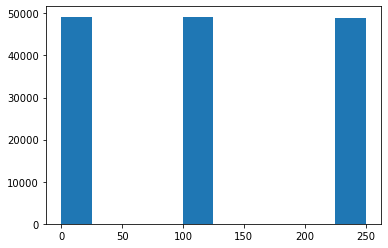

In [58]:
plt.hist(df.loc[df['group']=='treatment', 'revenue']);

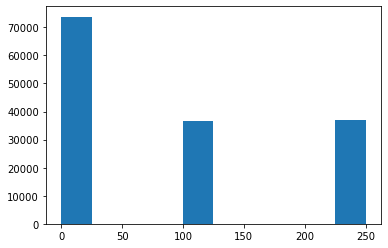

In [59]:
plt.hist(df.loc[df['group']=='control', 'revenue']);

In [61]:
b = df.loc[df['group']=='treatment', 'revenue'].values
a = df.loc[df['group']=='control', 'revenue'].values

In [62]:
from sklearn.utils import resample

a_means = []
b_means = []

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

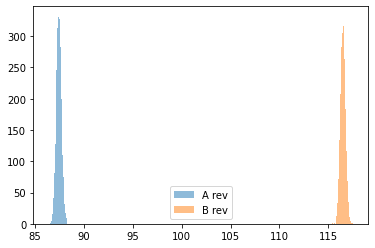

In [73]:
plt.hist(a_means, label='A rev', alpha=0.5, bins=100)
plt.hist(b_means, label='B rev', alpha=0.5, bins=100)

plt.legend()
plt.show()

In [64]:
# доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(86.91151444953194, 87.95057132375919)

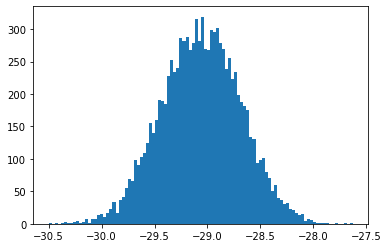

In [65]:
plt.hist(a_means - b_means, bins=100)
plt.show()

In [66]:
# сделаем оценку на p_value
dff = a_means - b_means
len(dff[dff>=0])/len(dff)

0.0

In [72]:
dff.mean()

-29.061082249127455

Вывод: Применение новой версии дизайна сайта, статистически значимо увеличило средний чек в среднем на 29 рублей, в то же время конверсия сайта не изменилась при уровне статистической значимости a = 0.05